# ASTR 496: Foundations of Data Science in Astronomy
# Fitting a Stellar Binary Orbit with MCMC using `emcee`
### Gautham Narayan

## Introduction

You are going to use Markov Chain Monte Carlo (MCMC) to fit the radial velocity curve of a binary star system. This is a fairly common problem in astrophysics where we observe the Doppler shift of spectral lines as stars orbit their common center of mass. You've already modeled a transit for an exoplanet light curve, so might as well model the other common method to find them.


I'll give you the physical setup - 

A binary star system with one visible component shows periodic radial velocity variations:

$$v_r(t) = K \sin\left(\frac{2\pi(t - t_0)}{P}\right) + v_0$$

where:
- $K$ = velocity semi-amplitude (km/s)
- $P$ = orbital period (days)
- $t_0$ = time of periastron passage (days)
- $v_0$ = systemic velocity (km/s)

In [1]:
# Import required packages
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
from scipy import stats
# import whatever else you want here

# Set random seed for reproducibility
np.random.seed(42) # the answer to Life, the Universe, Everything

# Plotting style
%matplotlib ipympl

### Next, I'll create synthetic observations of a binary star system with known parameters, then add observational noise.

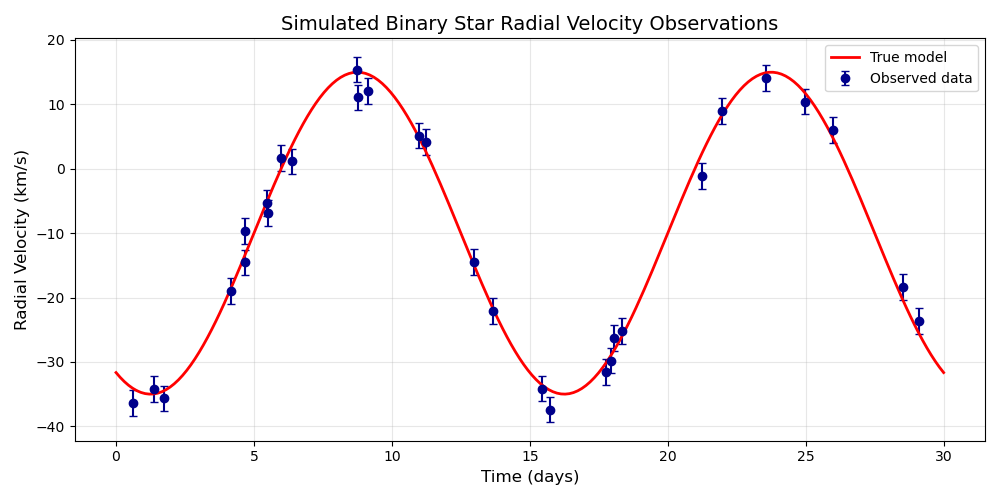

True parameters:
  K  = 25.0 km/s
  P  = 15.0 days
  t0 = 5.0 days
  v0 = -10.0 km/s


In [2]:
# True parameters (these are what we'll try to recover)
K_true = 25.0      # km/s
P_true = 15.0      # days
t0_true = 5.0      # days
v0_true = -10.0    # km/s

# Observation setup
n_obs = 30
t_obs = np.sort(np.random.uniform(0, 30, n_obs))  # Random times over 30 days
v_err = 2.0  # Measurement uncertainty (km/s)

# Model function
def radial_velocity_model(t, K, P, t0, v0):
    """Calculate radial velocity at time t for circular orbit"""
    phase = 2 * np.pi * (t - t0) / P
    return K * np.sin(phase) + v0

# Generate true signal
v_true = radial_velocity_model(t_obs, K_true, P_true, t0_true, v0_true)

# Add Gaussian noise
v_obs = v_true + np.random.normal(0, v_err, n_obs)

# Plot the data
plt.figure(figsize=(10, 5))
plt.errorbar(t_obs, v_obs, yerr=v_err, fmt='o', label='Observed data', 
             color='darkblue', markersize=6, capsize=3)
t_model = np.linspace(0, 30, 200)
v_model = radial_velocity_model(t_model, K_true, P_true, t0_true, v0_true)
plt.plot(t_model, v_model, 'r-', label='True model', linewidth=2)
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel('Radial Velocity (km/s)', fontsize=12)
plt.title('Simulated Binary Star Radial Velocity Observations', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"True parameters:")
print(f"  K  = {K_true:.1f} km/s")
print(f"  P  = {P_true:.1f} days")
print(f"  t0 = {t0_true:.1f} days")
print(f"  v0 = {v0_true:.1f} km/s")

### OK now for the homework:

For MCMC, we need to define:
1. **Log-likelihood**: How well does a model fit the data?
2. **Log-prior**: What do we know before seeing the data?
3. **Log-posterior**: Combination of likelihood and prior (what we sample)

In [3]:
def log_likelihood(theta, t, v, v_err):
    """
    Calculate the log-likelihood of the model given the data.
    
    Parameters:
    -----------
    theta : array
        Model parameters [K, P, t0, v0]
    t : array
        Observation times
    v : array
        Observed velocities
    v_err : float
        Measurement uncertainty
    """
    K, P, t0, v0 = theta
    model = radial_velocity_model(t, K, P, t0, v0)
    sigma2 = v_err**2
    return -0.5 * np.sum((v - model)**2 / sigma2 + np.log(2 * np.pi * sigma2))

def log_prior(theta):
    """
    Define uniform priors on parameters.
    Returns -inf if parameters are outside allowed ranges.
    """
    K, P, t0, v0 = theta
    
    # Set physically reasonable bounds
    if 0 < K < 100 and 1 < P < 50 and 0 < t0 < 50 and -50 < v0 < 50:
        return 0.0  # Uniform prior (constant)
    return -np.inf  # Outside bounds

def log_probability(theta, t, v, v_err):
    """
    Calculate the log-posterior probability.
    This is what emcee will sample.
    """
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, t, v, v_err)


print("\nPrior ranges:")
print("  K:  (0, 100) km/s")
print("  P:  (1, 50) days")
print("  t0: (0, 50) days")
print("  v0: (-50, 50) km/s")


Prior ranges:
  K:  (0, 100) km/s
  P:  (1, 50) days
  t0: (0, 50) days
  v0: (-50, 50) km/s


#### Justify the choice of prior in a few sentences

ANSWER GOES HERE

#### Describe how you treated the uncertainties in a few sentences


ANSWER GOES HERE


#### Next setup the MCMC. 

Use the affine-invariant ensemble sampler from `emcee`. This requires:
- Initial positions for multiple "walkers" (independent MCMC chains)
- Number of steps to run

**Rule of thumb**: Use at least 2×(number of parameters) walkers.

In [4]:
# MCMC setup
ndim = 4  # Number of parameters
nwalkers = 32  # Number of walkers (should be >> ndim)
nsteps = 10000  # Number of steps per walker

# Initial positions: add small random scatter around a guess
initial_guess = np.array([20.0, 14.0, 6.0, -8.0])  # Deliberately not perfect
pos = initial_guess + 1e-1 * np.random.randn(nwalkers, ndim)

print(f"Setting up emcee sampler:")
print(f"  Number of dimensions: {ndim}")
print(f"  Number of walkers: {nwalkers}")
print(f"  Number of steps: {nsteps}")
print(f"\nInitial guess: K={initial_guess[0]:.1f}, P={initial_guess[1]:.1f}, "
      f"t0={initial_guess[2]:.1f}, v0={initial_guess[3]:.1f}")

Setting up emcee sampler:
  Number of dimensions: 4
  Number of walkers: 32
  Number of steps: 10000

Initial guess: K=20.0, P=14.0, t0=6.0, v0=-8.0


#### Run the MCMC Sampler
This may take a minute or two.

In [5]:
# Initialize the sampler
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, 
    args=(t_obs, v_obs, v_err)
)

# Run MCMC
print("Running MCMC...")
sampler.run_mcmc(pos, nsteps, progress=True)
print("\nDone!")

# Get the acceptance fraction
print(f"\nMean acceptance fraction: {np.mean(sampler.acceptance_fraction):.3f}")
print("(Ideal range: 0.2-0.5)")

Running MCMC...


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:03<00:00, 3211.56it/s]


Done!

Mean acceptance fraction: 0.595
(Ideal range: 0.2-0.5)


#### Analyze the Chains

i.e. heck if the chains have "converged" (reached the posterior distribution).
Do this by plotting the `nsteps` samples from all `nwalkers` chains 

**Key concepts:**

- **Autocorrelation time**: How many steps until samples are independent
- **Burn-in**: Initial steps where walkers move from initial positions to the posterior
- **Thinning**: take every n'th sample from the chains to reduce the autocorrelation


You can look at the slides for notes on this. Make some reasonable choices! Or if you don't have a good sense, you can use a burn-in that is twice the maximum autocorrelation time, and thinning of 1/2 the minimum autocorrelation time. This implies that there are multiple autocorrelation times, and you have to figure out how. 

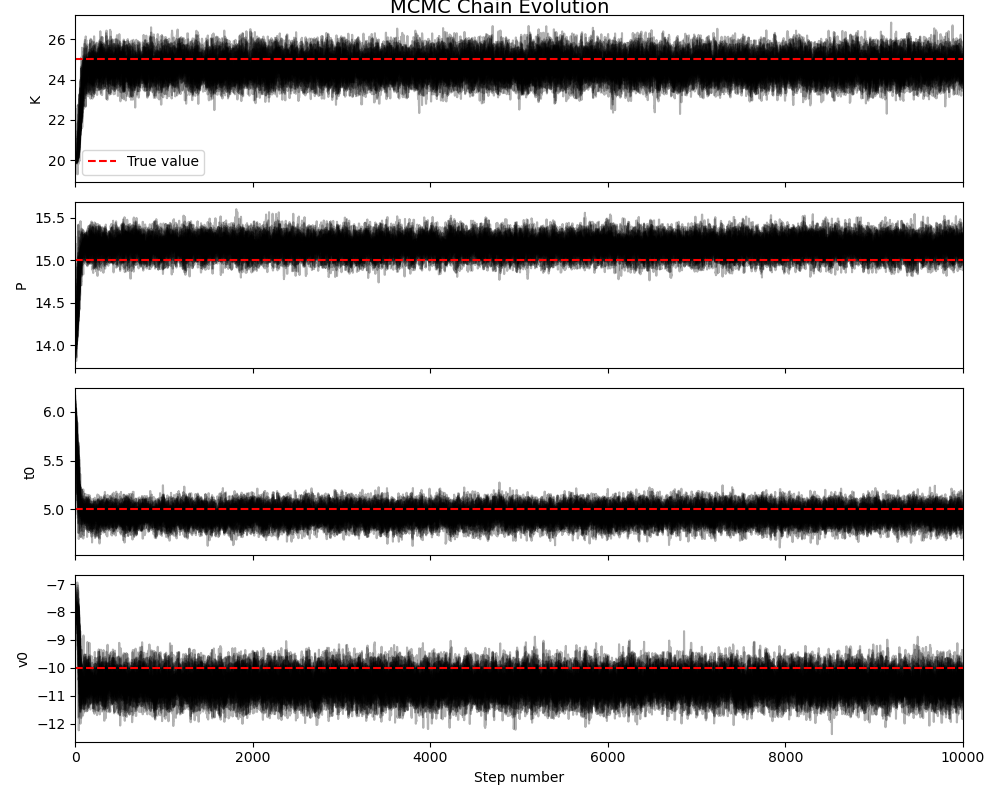


Autocorrelation times:
  K: 57.6 steps
  P: 47.6 steps
  t0: 45.7 steps
  v0: 45.9 steps

Recommended burn-in: 115 steps
Recommended thinning: every 22 steps


In [6]:
# Plot the chains
samples = sampler.get_chain()
labels = ["K", "P", "t0", "v0"]

fig, axes = plt.subplots(4, figsize=(10, 8), sharex=True)
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.axhline(y=[K_true, P_true, t0_true, v0_true][i], 
               color='r', linestyle='--', label='True value')
    if i == 0:
        ax.legend()

axes[-1].set_xlabel("Step number")
plt.tight_layout()
plt.suptitle('MCMC Chain Evolution', y=1.002, fontsize=14)
plt.show()

# Calculate autocorrelation time
try:
    tau = sampler.get_autocorr_time()
    print("\nAutocorrelation times:")
    for i, label in enumerate(labels):
        print(f"  {label}: {tau[i]:.1f} steps")
    
    burnin = int(2 * np.max(tau))
    thin = int(0.5 * np.min(tau))
    print(f"\nRecommended burn-in: {burnin} steps")
    print(f"Recommended thinning: every {thin} steps")
except emcee.autocorr.AutocorrError:
    print("\nWarning: Chains may not have converged yet.")
    burnin = 1000
    thin = 15
    print(f"Using default burn-in: {burnin} steps")
    print(f"Using default thinning: every {thin} steps")

#### Extract and Analyze Results

After discarding burn-in, you'll extract the posterior samples and calculate parameter estimates.

In [7]:
# Get flattened samples (discard burn-in and thin)
flat_samples = sampler.get_chain(discard=burnin, thin=thin, flat=True)
print(f"Total posterior samples: {len(flat_samples)}")

# Calculate parameter estimates
print("\n" + "="*60)
print("PARAMETER ESTIMATES")
print("="*60)

true_values = [K_true, P_true, t0_true, v0_true]
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    
    print(f"\n{labels[i]}:")
    print(f"  True value:     {true_values[i]:.3f}")
    print(f"  MCMC estimate:  {mcmc[1]:.3f} +{q[1]:.3f} -{q[0]:.3f}")
    print(f"  Difference:     {abs(mcmc[1] - true_values[i]):.3f}")

print("\n" + "="*60)

Total posterior samples: 14368

PARAMETER ESTIMATES

K:
  True value:     25.000
  MCMC estimate:  24.652 +0.520 -0.525
  Difference:     0.348

P:
  True value:     15.000
  MCMC estimate:  15.160 +0.099 -0.098
  Difference:     0.160

t0:
  True value:     5.000
  MCMC estimate:  4.944 +0.076 -0.075
  Difference:     0.056

v0:
  True value:     -10.000
  MCMC estimate:  -10.585 +0.398 -0.391
  Difference:     0.585



#### Create a Corner Plot

A corner plot shows all 1D and 2D marginalized distributions, revealing parameter correlations.

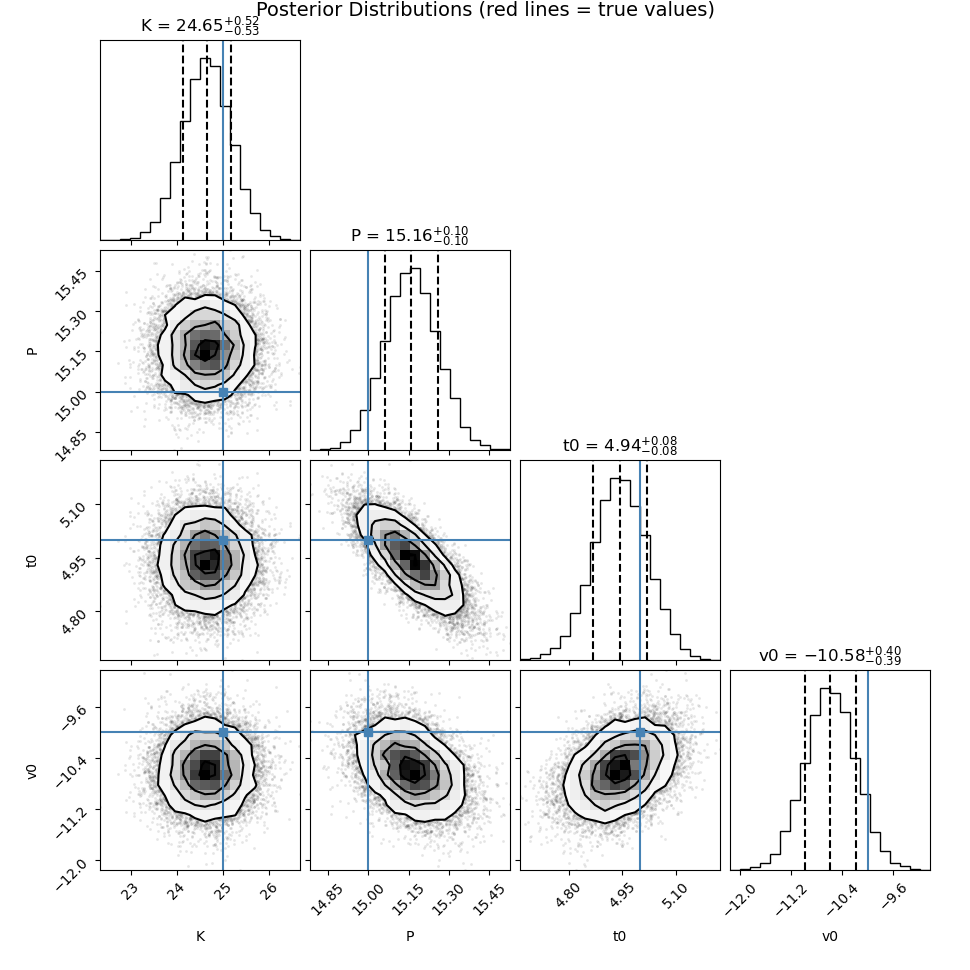

In [8]:
# Create corner plot
fig = corner.corner(
    flat_samples,
    labels=labels,
    truths=true_values,
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
)

plt.suptitle('Posterior Distributions (red lines = true values)', 
             y=1.0, fontsize=14)
plt.show()

#### Plot the Best-Fit Model
LOOK AT YOUR DATA. Take the median estimate to be the "best-fit"
Plot some confidence interval

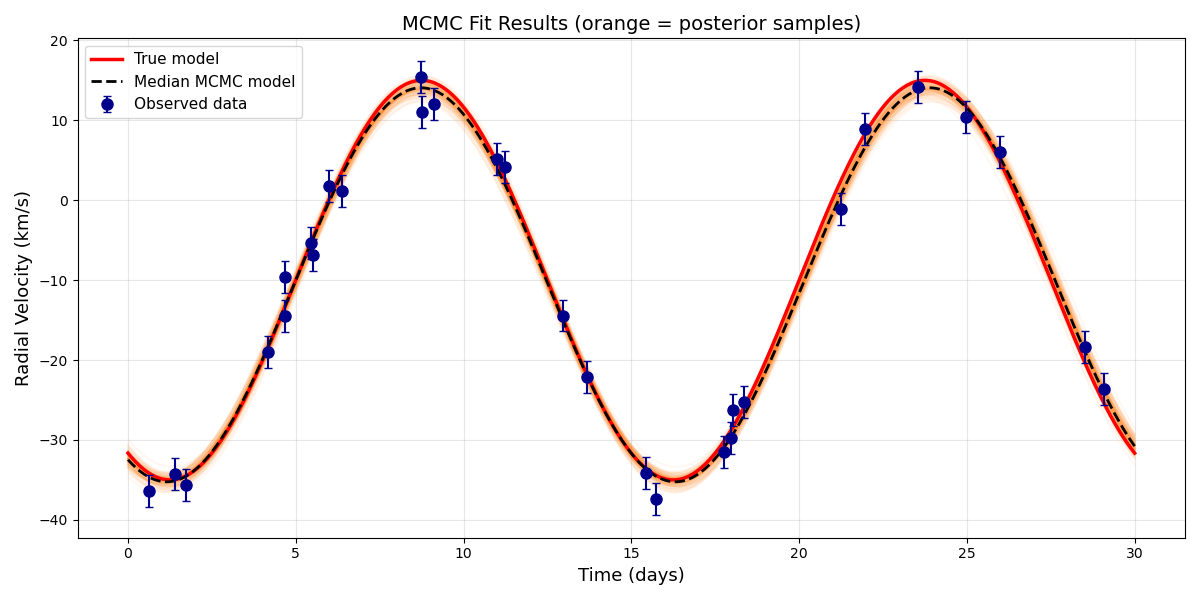


Orange envelope shows the range of models consistent with the data.


In [9]:
# Create fine time grid for plotting
t_plot = np.linspace(0, 30, 500)

# Plot data
plt.figure(figsize=(12, 6))
plt.errorbar(t_obs, v_obs, yerr=v_err, fmt='o', 
             label='Observed data', color='darkblue', 
             markersize=8, capsize=3, zorder=3)

# Plot random samples from posterior (to show uncertainty)
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(t_plot, radial_velocity_model(t_plot, *sample), 
             "C1", alpha=0.05)

# Plot true model
plt.plot(t_plot, radial_velocity_model(t_plot, K_true, P_true, t0_true, v0_true),
         'r-', linewidth=2.5, label='True model', zorder=2)

# Plot median posterior model
median_params = np.median(flat_samples, axis=0)
plt.plot(t_plot, radial_velocity_model(t_plot, *median_params),
         'k--', linewidth=2, label='Median MCMC model', zorder=2)

plt.xlabel('Time (days)', fontsize=13)
plt.ylabel('Radial Velocity (km/s)', fontsize=13)
plt.title('MCMC Fit Results (orange = posterior samples)', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nOrange envelope shows the range of models consistent with the data.")

Finally, again a few sentences here:

**Correlations**: Examine the corner plot. Are any parameters correlated? Why might K and v₀ show correlation?

ANSWER GOES HERE

**Uncertainty**: Compare the posterior uncertainties to the true values. Did our MCMC analysis recover the true parameters within the error bars?

ANSWER GOES HERE

**Sensitivity**: What happens if you increase the measurement uncertainty (`v_err`)? Try changing it to 10.0 km/s and rerun.

ANSWER GOES HERE - make a copy of the notebook if you need to, but just save the final plot you create above and discuss here

**Sampling**: What would happen if you used too few walkers (e.g., nwalkers=4)? Too few steps?


ANSWER GOES HERE - make a copy of the notebook if you need to, but just save the final plot you create above and discuss here
